# IBM 推荐系统


## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV.[基于内容的推荐方法（选修内容）](#Content-Recs)<br>
V. [矩阵分解](#Matrix-Fact)<br>
VI.[其他内容和总结](#conclusions)

你可以在 notebook 的结尾处找到提交 notebook 的指南。首先导入必要的库并读取数据。

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [229]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [230]:
print(df.shape)
df_content.head(12)

(45993, 3)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [195]:
df_content.loc[df_content['article_id'].isin([2.0,7.0])].doc_full_name.values.tolist()

['This Week in Data Science (April 18, 2017)', 'Data Wrangling at Slack']

In [196]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>

通过以下字典和单元格了解数据的描述性统计信息。

`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

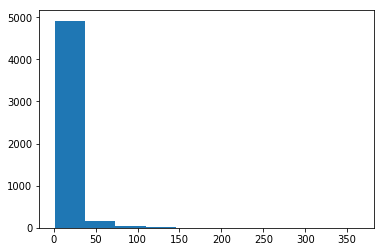

In [197]:
plt.hist(df['user_id'].value_counts()); # Distribution of the number of interactions

In [198]:
# Fill in the median and maximum number of user_article interactios below

median_val =df.groupby('user_id')['article_id'].count().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =df.groupby('user_id')['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is ______.

In [199]:
article_interaction=df.groupby('article_id')['user_id'].count().reset_index().sort_values(by='user_id',ascending=False)
article_interaction.rename(columns={'user_id':'number of users'},inplace=True)
article_interaction.head()

,article_id,number of users
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


`2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [200]:
# Find and explore duplicate articles
df_content.drop_duplicates('doc_full_name',inplace=True)
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [201]:
df_content.shape #check the number of current blogs and know the number deleted

(1051, 5)

In [202]:
# Remove any rows that have the same article_id - only keep the first

`3.` 在以下单元格中查找：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [203]:
unique_articles =df['article_id'].unique().shape[0] # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].unique().shape[0]# The number of unique articles on the IBM platform
unique_users =df['user_id'].unique().shape[0] # The number of unique users
user_article_interactions =df.shape[0] # The number of user-article interactions

In [204]:
df['user_id'].isnull().mean()

0.0

`4.` 在以下单元格中查找查看次数最多的文章的 **article_id**，以及被查看频率。在与公司领导讨论后，`email_mapper` 函数被视为将用户映射到 ID 的合理方式。有少数几个空值，并且所有这些空值都可能属于一个用户（我们以这种方式使用以下函数存储了这些值）。

In [205]:
most_viewed_article_id = str(article_interaction.iloc[0,0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views =article_interaction.iloc[0,1] # The most viewed article in the dataset was viewed how many times?

In [206]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The number of unique users in the dataset is ______` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

与之前的课程不同，我们没有关于用户是否喜欢某篇文章的评分。我们只知道用户与文章互动了。在这些情形下，文章的热门程度只能通过用户与文章的互动频率来判断。

`1.` 填写以下函数，使其返回前 **n** 篇文章，按照互动次数从高到低排序。使用以下测试测试你的函数。

In [207]:
article_interaction=article_interaction.merge(df,on='article_id',how='left').drop_duplicates('article_id')# merge the df and article_interaction
def get_top_articles(n, df=article_interaction):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles=list(df['title'][:n])
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=article_interaction):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles=list(df['article_id'][:n])
    return top_articles # Return the top article ids

In [208]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [209]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 使用以下函数调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。


* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 

使用以下测试检验矩阵的基本结构是否与解答中的结构一致。

In [210]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [211]:
#create user by article
user_by_article=df.groupby(['user_id','article_id'])['title'].max().unstack()#generate the dataframe describing the relationship between user_id and artilce
user_by_article=user_by_article.applymap(lambda x:0 if pd.isnull(x) else 1)
user_by_article.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
user_item.loc[:,1394.0].sum()

127

In [213]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_by_article=df.groupby(['user_id','article_id'])['title'].max().unstack()#generate the dataframe describing the relationship between user_id and artilce
    user_item=user_by_article.applymap(lambda x:0 if pd.isnull(x) else 1)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [214]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` 完成以下函数，该函数应该接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回的列表不应包含提供的 user_id，因为我们知道每个用户都与其本身相似。因为每个用户的结果是二元的，所以建议用两个用户的点积表示相似性。 

使用测试测试你的函数。

In [215]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    size=user_item.shape[0]
    list=[]
    user1=user_item.loc[user_id].values
    for i in range(1,size):
        user2=user_item.loc[i].values
        dist = np.linalg.norm(user1-user2)
        actions=user_item.loc[user2].sum()
        list.append([i,dist,actions])
    # sort by similarity
    df_corr=pd.DataFrame(list,columns=['user_id','dist','action']).sort_values(by='dist',ascending=True)
    # create list of just the ids
    id_list=df_corr['user_id'].values.tolist()
    # remove the own user's id
    id_list.remove(user_id)  
    return id_list # return a list of the users in order from most to least similar
        

In [216]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    size=user_item.shape[0]
    list=[]
    user1=user_item.loc[user_id].values
    for i in range(1,size):
        user2=user_item.loc[i].values
        dist = np.linalg.norm(user1-user2)
        actions=user_item.loc[i].sum()
        list.append([i,dist,actions])
    # sort by similarity
    neighbors_df=pd.DataFrame(list,columns=['neighbors_id','similarity','num_interactions']).sort_values(by=['similarity','num_interactions'],ascending=True)
    return neighbors_df # Return the dataframe specified in the doc_string

In [217]:
user_item.loc[3353].mean()

0.056022408963585436

In [218]:
get_top_sorted_users(3).head(20)

,neighbors_id,similarity,num_interactions
2,3,0.000000,40
3352,3353,0.000000,40
1214,1215,6.000000,4
4695,4696,6.000000,4
893,894,6.082763,3
1093,1094,6.082763,3
1358,1359,6.082763,3
1634,1635,6.082763,3
3666,3667,6.082763,3
3832,3833,6.082763,3


In [219]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

C:\application\anaconda\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


The 10 most similar users to user 1 are: [3933, 824, 253, 5034, 2305, 4020, 4504, 3031, 136, 2447]
The 5 most similar users to user 3933 are: [1, 253, 824, 5034, 3031]
The 3 most similar users to user 46 are: [4201, 790, 824]


`3.` 创建了为每个用户提供最相似用户的函数后，你需要使用这些用户查找可以推荐的文章。完成以下函数，以返回向每个用户推荐的文章。

In [220]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    titles=[]
    for i in article_ids:
        titles.append(df[df['article_id']==int(float(i))]['title'].unique()[0])
   
    return titles # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids=user_item.loc[user_id,user_item.loc[user_id]==1].index.tolist()
    article_names=get_article_names(article_ids, df=df)
    article_ids=[str(x) for x in article_ids]
    #article_names=df_content.loc[df_content['article_id'].isin(article_ids)].doc_full_name.values.tolist()
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs=[]
    have_seen_id,have_seen_title=get_user_articles(user_id, user_item=user_item)
    similar_users=find_similar_users(user_id)
    for id in similar_users:
        article_ids, article_names=get_user_articles(id, user_item=user_item)
        recs.extend(article_ids)
        recs=list(set(recs).difference(set(have_seen_id)))
        if(len(recs)>m):
            break
    
    return recs[0:m] # return your recommendations for this user_id    

In [221]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

C:\application\anaconda\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


['the nurse assignment problem data',
 '9 mistakes to avoid when starting your career in data science',
 'use spark for python to load data and run sql queries',
 'customer demographics and sales',
 'ml optimization using cognitive assistant',
 'this week in data science (may 30, 2017)',
 'self-service data preparation with ibm data refinery',
 'movie recommender system with spark machine learning',
 'getting started with python',
 'analyze precipitation data']

In [222]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。你可以利用之前编写的 **top_articles** 函数获得这种排名。

In [278]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    size=user_item.shape[0]
    list=[]
    user1=user_item.loc[user_id].values
    for i in range(1,size):
        user2=user_item.loc[i].values
        dist = np.linalg.norm(user1-user2)
        actions=user_item.loc[i].sum()
        list.append([i,dist,actions])
    # sort by similarity
    neighbors_df=pd.DataFrame(list,columns=['neighbors_id','similarity','num_interactions']).sort_values(by=['similarity','num_interactions'],ascending=[True,False])
    neighbors_df.drop(index=neighbors_df[neighbors_df['neighbors_id']==user_id].index,inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    neighbors_df=get_top_sorted_users(user_id)
    similar_users=neighbors_df['neighbors_id'].values.tolist()
    recs=[]
    have_seen_id,have_seen_title=get_user_articles(user_id, user_item=user_item)
    for id in similar_users:
        article_ids, article_names=get_user_articles(id, user_item=user_item)
        recs.extend(article_ids)
        recs=list(set(recs).difference(set(have_seen_id)))
        if(len(recs)>m):
            break
    article_interaction=[]
    for id in recs:
        article_interaction.append(user_item.loc[:,int(float(id))].sum())
    data= list(zip(recs,article_interaction))
    title_list=get_article_names(recs)
    rec_df=pd.DataFrame(data,columns=['recs_id','num_of_interaction'])
    rec_df['title']=title_list
    rec_df=rec_df.sort_values(by='num_of_interaction',ascending=False)
    rec_id=rec_df['recs_id'][0:m].values.tolist()
    rec_names=rec_df['title'][0:m].values.tolist()
    
    return rec_id, rec_names

In [287]:
get_top_sorted_users(131)['neighbors_id'].values[9]


132

`5.` 请利用上述函数正确填写以下字典。然后对照解答检验该字典。按照以下注释提供必要的代码。

In [281]:
### Tests with a dictionary of results

user1_most_sim =get_top_sorted_users(1)['neighbors_id'].values[0]# Find the user that is most similar to user 1 
user131_10th_sim =get_top_sorted_users(131)['neighbors_id'].values[9]# Find the 10th most similar user to user 131


132

In [289]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.':user1_most_sim, 
    'The user that is the 10th most similar to user 131':user131_10th_sim
}

t.sol_5_test(sol_5_dict)

TypeError: 'numpy.int64' object is not iterable

`6.` 如果是新用户，你可以使用上述哪个函数做出推荐？请解释。你能想到更好的推荐方法吗？在以下单元格中解释向新用户做出推荐的更好方法。

**请在此处填写答案。**

`7.` 利用现有函数向以下新用户提供前 10 篇推荐文章。你可以对照我们的解答测试你的函数，确保在如何做出推荐方面与我们的想法一致。

In [293]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs =[str(x) for x in get_top_article_ids(10)] # Your recommendations here



In [294]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">第四部分：基于内容的推荐方法（选修内容）</a>

另一种推荐方法是对与某个术语相关的文章进行从高到低排名。内容可以是 **doc_body**、**doc_description** 或**doc_full_name**。创建基于内容的推荐系统并非只有一种方式，尤其是考虑到每列都包含与内容相关的信息。  

`1.` 使用以下函数主体创建一个基于内容的推荐系统。由于这个推荐系统的正确答案不止一个，所以没有提供测试函数。如果你想尝试一种需要更多输入值的方法，可以更改函数输入。当前的输入值考虑到了你可能会使用基于内容的推荐方法。此外，你可能会使用满足“内容标准”的最热门推荐方法，总之，你在做出这些推荐时可以灵活选择方法。

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` 你已经创建了基于内容的推荐系统，接着在以下单元格中简要说明下这一基于内容的推荐系统是如何运行的。你觉得你的函数有哪些值得改进的地方吗？这一基于内容的推荐系统有什么新奇的地方吗？

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

**在此处解释下这一基于内容的推荐系统。**

`3.` 根据注释使用这一基于内容的推荐系统对以下情形做出推荐。我们没有提供测试，因为在创建此基于内容的推荐系统时，可以有多个正确答案。

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

在此部分，你将利用矩阵分解向 IBM Watson Studio 平台上的用户推荐文章。

`1.` 你在上述**第三部分**的**第一个问题**中已经创建了 **user_item** 矩阵。接下来的第一个问题需要你运行单元格，为**第五部分**的其他步骤做好准备。

In [295]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [296]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，你可以对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [300]:
# Perform SVD on the User-Item Matrix Here

u, s, vt =np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape

(714,)

**请在此处填写答案。**

`3.` 如何确定潜在特征的数量？这个问题比较难。运行以下单元格后你会发现，随着潜在特征数量的增加，用户-项目矩阵中 1 和 0 值的预测错误率会降低。运行以下单元格，了解当潜在特征的数量增加时，准确率会如何提高。

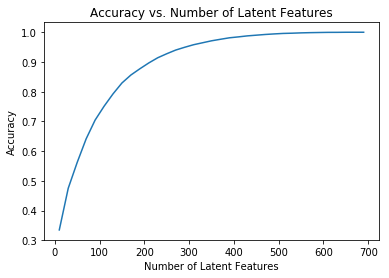

In [301]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。我们可以将数据集划分为训练集和测试集，如以下单元格所示。  

根据第三个问题的代码判断，不同的潜在特征数量对训练集和测试集的准确率有何影响。使用以下划分方法： 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [310]:
user_item_train=create_user_item_matrix(df.tail(5993))
user_item_train.columns

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1432.0, 1433.0, 1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0,
              1441.0, 1443.0],
             dtype='float64', name='article_id', length=574)

In [325]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train=create_user_item_matrix(df_train)
    user_item_test=create_user_item_matrix(df_test)
    test_idx=user_item_test.index
    test_arts=user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [352]:
list1=user_item_train.index.tolist()
list2=test_idx
list(set(list1).intersection(set(list2)))#find the data of test_set which have been trained in train_set 

[3968,
 4487,
 4231,
 3093,
 3989,
 3990,
 3740,
 3998,
 4002,
 4274,
 3777,
 4293,
 3527,
 3532,
 3024,
 3801,
 3684,
 2917,
 4204,
 3193]

In [323]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c ,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, # letter here, 
    'How many movies can we make predictions for in the test set?':b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [346]:
def funksvd(df,latent_features=70,learning_rate=0.002,iters=50):
    df=np.matrix(df)
    n_users=int(df.shape[0])
    n_articles=int(df.shape[1])
    mat_sign=np.count_nonzero(~np.isnan(df))# told by whether the article(j) be read by user(i)
    user_mat=np.random.rand(n_users,latent_features)
    article_mat=np.random.rand(latent_features,n_articles)
    sse_accm=0
    print("starting to fit")
    print("iterarion|mean square error")
    for iteration in range(iters):
        old_see=sse_accm
        sse_accm=0
        for i in range(n_users):
            for j in range(n_articles):
                if(df[i,j]>0):
                    diff=df[i,j]-np.dot(user_mat[i,:],article_mat[:,j])
                    sse_accm+=diff**2
                    for k in range(latent_features):
                        user_mat[i,k]+=learning_rate*(2*diff*article_mat[k,j])
                        article_mat[k,j]+=learning_rate*(2*diff*user_mat[i,k])
        print("%d\t\t %f"%(iteration+1,sse_accm/mat_sign))
    return user_mat,article_mat
user_mat,article_mat=funksvd(user_item_train)

starting to fit
iterarion|mean square error
1		 0.331069
2		 0.035553
3		 0.017632
4		 0.011149
5		 0.007908
6		 0.006004
7		 0.004770
8		 0.003916
9		 0.003296
10		 0.002829
11		 0.002465
12		 0.002175
13		 0.001939
14		 0.001743
15		 0.001578
16		 0.001437
17		 0.001316
18		 0.001209
19		 0.001116
20		 0.001033
21		 0.000960
22		 0.000894
23		 0.000834
24		 0.000780
25		 0.000732
26		 0.000687
27		 0.000646
28		 0.000609
29		 0.000575
30		 0.000544
31		 0.000515
32		 0.000488
33		 0.000463
34		 0.000440
35		 0.000419
36		 0.000399
37		 0.000381
38		 0.000363
39		 0.000347
40		 0.000332
41		 0.000318
42		 0.000305
43		 0.000293
44		 0.000281
45		 0.000270
46		 0.000260
47		 0.000250
48		 0.000241
49		 0.000233
50		 0.000225


In [347]:
def predict(user_matrix,article_matrix,user_id,article_id):
    user_id_series=np.array(user_item_train.index)
    movie_id_series=np.array(user_item_train.columns)
    user_row=np.where(user_id_series==user_id)[0][0]
    movie_col=np.where(movie_id_series==article_id)[0][0]
    pred=np.dot(user_matrix[user_row,:],article_matrix[:,movie_col])
    return pred

In [354]:
predict(user_mat,article_mat,4274,14)

0.29382697683898906

`5.` 现在对上述 **user_item_train** 数据集进行奇异值分解，并得出 U、S 和 V 转置矩阵。然后判断在使用不同的潜在特征数量时，可以使用此矩阵分解方法对 **user_item_test** 数据集中的多少行做出预测，并根据测试数据的准确率确定应该保留多少个潜在特征。这个问题需要运用在第 `2` - `4`.个问题中完成的步骤。

通过以下单元格了解 SVD 在测试数据上做出推荐预测的效果如何。

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` 在以下单元格中解释上个问题的结果。根据你得出的结果，讨论下你会如何判断上述推荐系统是否比用户目前查找文章的方式更好。 

**请在此处填写答案。**

<a id='conclusions'></a>
### 其他内容
你现在可以保存为每个用户推荐的文章，开发一个类来作出新的预测并更新结果，以及创建一个部署结果的应用。这些任务并不是此项目必须完成的任务。但是，在学完课程知识后，你肯定能够继续完成这些任务并改进你的项目。


## 总结

> 恭喜！你已经完成 IBM 推荐系统项目。 

> **小贴士**：当你对项目满意后，请检查报告并看看是否满足所有[审阅标准](https://review.udacity.com/#!/rubrics/2632/view)。请删除所有的**小贴士**（例如上方小贴士），使演示尽可能流畅。


## 提交指南

> 在提交项目之前，你需要在 workspace 的此部分创建 notebook 的 .html 或 .pdf 版本。运行以下单元格即可创建这两种版本。如果操作正确，系统会返回代码 0，并且你可以在 workspace 目录（点击左上角的橙色 Jupyter 图标）中看到生成的 .html 文件。

> 或者，你可以通过**文件** > **下载为**子菜单将此报告下载为 .html 文件，然后手动将报告上传到 workspace 目录中：点击左上角的橙色 Jupyter 图标，然后点击“上传”按钮。

> 完成这些步骤后，你可以点击右下角的“提交项目”按钮，提交项目。这样便会创建和提交一个 zip 文件，其中包含此 .ipynb 文件和你创建的 .html 或 .pdf 文件。恭喜！ 


```python
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])
```